**Otus Neural Networks**
# ДЗ №7. Q-learning. "Deep-Tac-Toe"


now based on draft version 8

In [1]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import cycle

In [2]:
import torch
import torch.nn as nn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Torch: {torch.__version__}, device: {device}")

Torch: 1.4.0, device: cpu


## Вспомогательные функции 
Вспомогательные функции для запуска агентов и вывода результатов обучения / тестов

In [3]:
def format_stats(stats, score=None):
    """
    generates stats strings with Wins Losses Draws percent for [X] and [O], [XO] combined
    :param stats: dictionary of results
    :param score: integral score. If not provided, calculated as % wins + 1/2 % draws
    output: 1-line formatted report 
    """
    if score is None:
        score = round(stats[-1][1] + stats[-1][0]/2, 1)
    s = [f"[X] {stats[0][1]:>.0f},{stats[0][-1]:>.0f},{stats[0][0]:>.0f}",
         f"[O] {stats[1][-1]:>.0f},{stats[1][1]:>.0f},{stats[1][0]:>.0f}",
         f"[XO] {stats[-1][1]:>.1f}, {stats[-1][-1]:>.1f}, {stats[-1][0]:>.1f}", ]
    return f"{s[0]:<12s} {s[1]:<12s} {s[2]:<21s} [SCORE] {score:2.1f}"


def test_agent(agent, opponents, num_episodes=1000):
    """
    Runs multiple test games between agent and each of opponents (both sides)
    """
    print(f"Testing agent '{agent.name}' for {num_episodes} games vs:")
    if not type(opponents) == list:
        opponents = [opponents]
    print(' '*16, "W, L, D      W, L, D       Win, Lose, Draw         score")
    for opp in opponents:
        stats, score = agent.test_many_games(
            player1=opp, num_episodes=num_episodes)
        print(f"{opp.name+':':<12s}", format_stats(stats))
    print()

In [4]:
def train_agent(agent, train_opponent=None, test_opponent=None,  max_games=25000, eps_anneal=None,
                test_num_episodes=1000, train_num_episodes=1000, early_stop=True, player_mark=None):
    """
    trains agent playing vs itself (TBD training vs opponent)
    periodically reports training stats vs `test_opponent`
    stops if reaches 100% draws (not a perfect measure of training success)
    :param test_opponent: Agent class object to test against
    :param max_games: overal max number of training games
    :param tests_number: number of test games at each checkpoint
    :param train_games_number: number of train games between checkpoints
    :param eps_anneal: number of games to reach zero epsilon
    """

    if train_opponent is None:
        train_opponent = Agent(name='Agent_0')  # .random_move
    if test_opponent is None:
        test_opponent = agent  # testing vs self

    score_list = []
    initial_epsilon = agent.epsilon
    improve_window = 5  # num. periods to show improvement, or stop training

    print(
        f"agent {agent.name} training vs {train_opponent.name}")
    print(f"     test opponent: {test_opponent.name}")
    report_header = "Games:     W, L, D      W, L, D       " \
                    "Win, Lose, Draw         score    epsilon"
    for i in tqdm(range(0, max_games+1, train_num_episodes)):
        if i == 0:
            print(report_header)
        print(f"{i:>5}: ", end='')

        if eps_anneal is not None:
            agent.epsilon = initial_epsilon * \
                max((eps_anneal-i)/(eps_anneal), 0)

        if i > 0:
            agent.learn_game(train_opponent=train_opponent,
                             num_episodes=train_num_episodes,
                             player_mark=player_mark)

        stats, score = agent.test_many_games(
            player1=test_opponent, num_episodes=test_num_episodes)
        print(format_stats(stats), f"[ε] {agent.epsilon:.3f}")
        score_list.append(score)

        if early_stop:
            if test_opponent == [agent]:  # testing agent vs itself
                if stats[-1][0] == 100:   # stop if always draw
                    print(
                        f"Training stopped after {i} iterations: 100% draws.")
                    return
            else:  # testing agent vs opponent
                if max(score_list[-improve_window:]) < max(score_list) and early_stop:
                    print(f"Training stopped after {i} iterations: " +
                          f"no progress for {improve_window*train_num_episodes} games")
                    return
        agent.train_history.append((i, stats, score))
    print(f"Training complete after {i} iterations.")


def plot_train_history(agent):
    """
    plots train history based on Agent().train_history data
    """
    x = [h[0] for h in agent.train_history]
    w0 = [h[1][0][1]/2 for h in agent.train_history]  # stats playing X
    l0 = [h[1][0][-1]/2 for h in agent.train_history]
    d0 = [h[1][0][0]/2 for h in agent.train_history]
    w1 = [h[1][1][-1]/2 for h in agent.train_history]  # stats playing O
    l1 = [h[1][1][1]/2 for h in agent.train_history]
    d1 = [h[1][1][0]/2 for h in agent.train_history]
    score = [h[2] for h in agent.train_history]

    fig, ax = plt.subplots(figsize=(16, 4))
    percent = [l1, l0, d1, d0, w1, w0]
    color_win, color_lose, color_draw = 'yellowgreen', 'steelblue', 'gold'
    hatches = ['o', '']
    colors = (color_lose, color_lose, color_draw,
              color_draw, color_win, color_win)
    stacks_labels = ['lose O', 'lose X', 'draw O', 'draw X', 'win O', 'win X']
    stacks = ax.stackplot(x, percent, colors=colors, labels=stacks_labels)
    for i, stack in enumerate(stacks):
        stack.set_hatch(hatches[i % 2])
    ax.plot(x, score, color='r', label='score')
    handles, labels = ax.get_legend_handles_labels()

    ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 0.8))

## Game class

In [5]:
class TicTacToeGame():
    """
    Класс игры в крестики-нолики на основе примера из класса. 
    Модифицирован для кодирования фишек 1 и -1.
    Модифицирован для ускорения работы (почти вдвое )
    """

    def __init__(self):
        self.state = tuple([0] * 9)
        self.player = 1
        self.winner = False
        self.symbols = {1: 'X', -1: 'O', 0: ' '}
        self.update_allowed_moves()

    def update_allowed_moves(self):
        self.allowed_moves = []
        self.all_moves = []
        self.vacant_cells = []
        for i in range(9):  # len(self.state)
            move = self.state[:i] + tuple([self.player]) + self.state[i+1:]
            self.all_moves.append(move)
            if not self.state[i]:
                self.vacant_cells.append(i)
                self.allowed_moves.append(move)

    def make_move(self, move):
        assert self.winner == 0, \
            "Game already completed, cannot make another move!"
        
        if type(move)==int:  # allows for int input
            move = self.all_moves[move]
        
        assert move in self.allowed_moves, \
            f"Cannot change state {self.state} to {move} for player {self.player}"

        self.state = move
        self.winner = self.predict_winner(self.state)
        if self.winner == 0:
            self.player = -self.player
            self.update_allowed_moves()
        return self.winner

    def playable(self):
        return not (self.winner or all(self.state))

    def predict_winner(self, state):
        lines = [(0, 1, 2), (3, 4, 5), (6, 7, 8), (0, 3, 6),
                 (1, 4, 7), (2, 5, 8), (0, 4, 8), (2, 4, 6)]
        winner = None
        for line in lines:
            line_state = state[line[0]] + state[line[1]] + state[line[2]]
            if line_state == 3:
                return 1
            elif line_state == -3:
                return -1
        return 0

    def print_board(self):
        s = [self.symbols[i] for i in self.state]
        print('     {} | {} | {} '.format(s[0], s[1], s[2]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[3], s[4], s[5]))
        print('    -----------')
        print('     {} | {} | {} '.format(s[6], s[7], s[8]))

    def print_result(self):
        if self.winner:
            print(f"\n{self.symbols[self.winner]} is the winner!")
        else:
            print("\nIt's a draw!")

## Agent class (table-based)

In [6]:
class Agent():
    def __init__(self, game_class=TicTacToeGame, name='Agent_instance', 
                 epsilon=0.3, alpha=0.9, player_mark=None):
        self.V = dict()
        self.NewGame = game_class
        self.name = name
        self.epsilon = epsilon
        self.alpha = alpha
        self.train_history = []

    def __call__(self, *args, **kwargs):
        """
        when object called as function - return best move
        """
        return self.play_select_move(*args, **kwargs)

    def state_value(self, game_state):
        return self.V.get(game_state, 0)

    def get_states_values(self, game):
        return {state: self.state_value(state) for state in game.allowed_moves}

    def play_select_move(self, game):
        allowed_state_values = self.get_states_values(game)
        best_val = max(allowed_state_values.values())  # for both X and O
        best_moves = [mov for mov, val in allowed_state_values.items() if val == best_val]
        return random.choice(best_moves)

    def learn_game(self, train_opponent, num_episodes=1000, player_mark=None):
        for episode in range(num_episodes):
            if player_mark is None:
                self.player_mark = 1 if episode % 2 else -1
            else:
                self.player_mark = player_mark
            self.learn_from_episode(train_opponent)

    def learn_from_episode(self, train_opponent):
        self.history = {'positions': [], 'moves': [], 'rewards': [],}
        game = self.NewGame()

        while game.playable():
            if game.player != self.player_mark:  # opponent's turn
                move = train_opponent(game)
                reward = game.make_move(move)
            else:  # Agent's turn
                self.learn_from_move(game)
        self.history['rewards'].append(game.winner * self.player_mark)  # only save reward once game over
        self.history['positions'].append(game.state)
        self.process_learning()

    def process_learning(self):
        """update policy table based on latest game"""
        for i in range(len(self.history['moves'])):
            move = self.history['moves'][i]
            td_target = self.history['rewards'][i+1]  # was i + 1
            current_state_value = self.state_value(move)
            self.V[move] = current_state_value + \
                self.alpha * (td_target - current_state_value)

    def learn_from_move(self, game):
        """
        make move and collect learning from it
        """
        self.history['positions'].append(game.state)
        best_next_move, selected_next_move = self.learn_select_move(game)
        self.history['moves'].append(selected_next_move)
        self.history['rewards'].append(
            self.state_value(best_next_move))
        game.make_move(selected_next_move)  # reward = ...

    def learn_select_move(self, game):
        """
        select move in learning mode using epsilon greedy
        """
        best_move = self.play_select_move(game)
        if random.random() < self.epsilon:
            selected_move = self.random_move(game)
        else:
            selected_move = best_move
        return best_move, selected_move

    def random_move(self, game):
        return random.choice(game.allowed_moves)

    def demo_game(self, player0, player1, verbose=False):
        """
        plays single game between 2 players
        """
        game = self.NewGame()
        t = 0
        while game.playable():
            current_player = [player0, player1][t % 2]
            move = current_player(game)
            game.make_move(move)
            if verbose:
                print(f"\nTurn {t} by 'Player {t%2}'")
                game.print_board()
            t += 1
        if verbose:
            game.print_result()
        return game.winner

    def test_many_games(self, player0=None, player1=None, num_episodes=1000, verbose=True):
        """ 
        Runs test matches between 2 opponents and delivers stats in form of 
        list of 3 dicts: for initial order, reverse order and average.
        each dict in stats has % of player wins, player 2 wins and draws.
        """
        player0 = self if player0 is None else player0
        player1 = self if player1 is None else player1
        results = []
        players = [[player0, player1], [player1, player0]]
        for p0, p1 in players:
            raw_results = []
            for i in range(num_episodes // 2):
                raw_results.append(self.demo_game(p0, p1, verbose=False))
            results.append(raw_results)
        return self.process_results(*results)

    def interactive_game(self, agent_player=1):
        """ 
        game with human opponent of class Human()
        enter 1 if Agent plays 'X' of -1 if Agent plays 'O'
        """
        if agent_player == -1:
            self.NewGame().print_board()  # show initial board to Human
            self.demo_game(Human(), self, verbose=True)
        else:
            self.demo_game(self, Human(), verbose=True)

    def process_results(self, results_x, results_o):
        stats = []
        keys_ = ([1, -1, 0], [-1, 1, 0])
        for r, key in zip((results_x, results_o), keys_):
            stats.append({k: round(r.count(k)/len(r)*100, 2) for k in key})
        # append average scores
        stats.append({k: round((stats[0][k] + stats[1][-k])/2, 2)
                      for k in stats[0].keys()})
        # reorder items in reversed stats dict
        stats[1] = {k: stats[1][k] for k in [-1, 1, 0]}
        score = round(stats[-1][1] + stats[-1][0]/2, 1)
        return stats, score


class Human(Agent):
    """ Human player class. Only has move entry function."""

    def play_select_move(self, game):
        allowed_moves = [i for i in range(9) if game.state[i] == 0]
        human_move = None
        while not human_move in allowed_moves:
            human_move = int(
                input(f'Choose move for {game.symbols[game.player]}, from {allowed_moves}: '))
        return human_move

## Тесты табличных агентов

In [7]:
""" RANDOM PLAYING AGENT """
agent_0 = Agent(name="Agent_0")

In [8]:
""" AGENT TRAINED TO PLAY X """
agent_x = Agent(name="Agent_X", epsilon=0.8)
train_agent (agent_x, train_opponent = agent_0, test_opponent=agent_0, 
             player_mark=1, eps_anneal=10000)

agent Agent_X training vs Agent_0
     test opponent: Agent_0


Games:     W, L, D      W, L, D       Win, Lose, Draw         score    epsilon
    0: [X] 62,26,12 [O] 25,62,13 [XO] 43.7, 44.0, 12.3 [SCORE] 49.9 [ε] 0.800
 1000: [X] 90,5,6   [O] 28,59,13 [XO] 59.0, 31.8, 9.2  [SCORE] 63.6 [ε] 0.720
 2000: [X] 93,4,3   [O] 23,63,14 [XO] 58.2, 33.3, 8.5  [SCORE] 62.5 [ε] 0.640
 3000: [X] 93,5,2   [O] 29,60,11 [XO] 60.9, 32.4, 6.7  [SCORE] 64.2 [ε] 0.560
 4000: [X] 99,0,1   [O] 28,58,14 [XO] 63.6, 29.1, 7.3  [SCORE] 67.2 [ε] 0.480
 5000: [X] 99,0,1   [O] 32,57,11 [XO] 65.9, 28.5, 5.6  [SCORE] 68.7 [ε] 0.400
 6000: [X] 98,1,1   [O] 29,62,9  [XO] 63.5, 31.6, 4.9  [SCORE] 66.0 [ε] 0.320
 7000: [X] 97,1,3   [O] 28,60,12 [XO] 62.1, 30.5, 7.4  [SCORE] 65.8 [ε] 0.240
 8000: [X] 99,1,0   [O] 27,60,13 [XO] 62.8, 30.5, 6.7  [SCORE] 66.1 [ε] 0.160
 9000: [X] 98,2,0   [O] 30,59,11 [XO] 64.2, 30.1, 5.7  [SCORE] 67.0 [ε] 0.080
10000: [X] 99,0,1   [O] 28,59,13 [XO] 63.4, 29.5, 7.1  [SCORE] 67.0 [ε] 0.000
Training stopped after 10000 iterations: no progress for 5000 g

In [9]:
""" AGENT TRAINED TO PLAY O """
agent_o = Agent(name="Agent_O", epsilon=0.8)
train_agent (agent_o, train_opponent = agent_0, test_opponent=agent_0, 
             player_mark=-1, eps_anneal=10000)

agent Agent_O training vs Agent_0
     test opponent: Agent_0


Games:     W, L, D      W, L, D       Win, Lose, Draw         score    epsilon
    0: [X] 58,27,14 [O] 28,61,11 [XO] 43.0, 44.2, 12.8 [SCORE] 49.4 [ε] 0.800
 1000: [X] 56,31,13 [O] 59,32,9  [XO] 57.5, 31.8, 10.7 [SCORE] 62.9 [ε] 0.720
 2000: [X] 63,24,13 [O] 67,26,7  [XO] 65.2, 25.2, 9.6  [SCORE] 70.0 [ε] 0.640
 3000: [X] 58,28,13 [O] 78,18,4  [XO] 68.2, 22.9, 8.9  [SCORE] 72.7 [ε] 0.560
 4000: [X] 58,31,12 [O] 82,13,5  [XO] 69.7, 21.9, 8.4  [SCORE] 73.9 [ε] 0.480
 5000: [X] 60,26,13 [O] 82,10,8  [XO] 71.0, 18.4, 10.6 [SCORE] 76.3 [ε] 0.400
 6000: [X] 57,26,16 [O] 82,12,6  [XO] 69.4, 19.4, 11.2 [SCORE] 75.0 [ε] 0.320
 7000: [X] 59,33,8  [O] 83,9,9   [XO] 70.9, 20.7, 8.4  [SCORE] 75.1 [ε] 0.240
 8000: [X] 58,30,12 [O] 79,10,11 [XO] 68.4, 19.8, 11.8 [SCORE] 74.3 [ε] 0.160
 9000: [X] 58,28,14 [O] 83,9,9   [XO] 70.3, 18.2, 11.5 [SCORE] 76.0 [ε] 0.080
10000: [X] 58,29,12 [O] 92,4,5   [XO] 75.1, 16.5, 8.4  [SCORE] 79.3 [ε] 0.000
11000: [X] 58,31,11 [O] 90,2,7   [XO] 74.4, 16.4, 9.2  [SCORE] 

In [10]:
""" AGENT TRAINED TO PLAY both X and O vs random """
agent_1 = Agent(name="Agent_1", epsilon=0.8)
train_agent (agent_1, train_opponent = agent_0, test_opponent=agent_0,
             player_mark=None, eps_anneal=10000)

agent Agent_1 training vs Agent_0
     test opponent: Agent_0


Games:     W, L, D      W, L, D       Win, Lose, Draw         score    epsilon
    0: [X] 58,27,15 [O] 27,61,12 [XO] 42.3, 44.2, 13.5 [SCORE] 49.0 [ε] 0.800
 1000: [X] 71,19,10 [O] 47,40,13 [XO] 58.7, 29.6, 11.7 [SCORE] 64.5 [ε] 0.720
 2000: [X] 92,3,5   [O] 54,34,13 [XO] 72.9, 18.1, 9.0  [SCORE] 77.4 [ε] 0.640
 3000: [X] 89,7,3   [O] 60,27,14 [XO] 74.4, 17.0, 8.6  [SCORE] 78.7 [ε] 0.560
 4000: [X] 88,6,6   [O] 71,17,12 [XO] 79.3, 11.4, 9.3  [SCORE] 84.0 [ε] 0.480
 5000: [X] 93,2,4   [O] 72,19,9  [XO] 82.7, 10.7, 6.6  [SCORE] 86.0 [ε] 0.400
 6000: [X] 92,5,3   [O] 78,15,7  [XO] 85.2, 10.1, 4.7  [SCORE] 87.5 [ε] 0.320
 7000: [X] 93,4,3   [O] 79,13,8  [XO] 86.1, 8.3, 5.6   [SCORE] 88.9 [ε] 0.240
 8000: [X] 98,0,2   [O] 71,17,11 [XO] 84.5, 8.8, 6.7   [SCORE] 87.8 [ε] 0.160
 9000: [X] 98,0,2   [O] 83,9,8   [XO] 90.5, 4.7, 4.8   [SCORE] 92.9 [ε] 0.080
10000: [X] 97,1,1   [O] 83,6,11  [XO] 90.0, 3.8, 6.2   [SCORE] 93.1 [ε] 0.000
11000: [X] 96,2,2   [O] 84,4,12  [XO] 90.3, 2.8, 6.9   [SCORE] 

In [11]:
""" AGENT TRAINED TO PLAY both X and O vs agent_1 """
agent_2 = Agent(name="Agent_2", epsilon = 0.8)
train_agent (agent_2, train_opponent = agent_1, test_opponent=agent_1,
             max_games=10000,  eps_anneal=5000)

agent Agent_2 training vs Agent_1
     test opponent: Agent_1


Games:     W, L, D      W, L, D       Win, Lose, Draw         score    epsilon
    0: [X] 0,90,9   [O] 0,99,1   [XO] 0.2, 94.5, 5.3   [SCORE] 2.9 [ε] 0.800
 1000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.640
 2000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.480
 3000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.320
 4000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.160
 5000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.000
 6000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.000
 7000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.000
 8000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.000
 9000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.000
10000: [X] 100,0,0  [O] 0,0,100  [XO] 50.0, 0.0, 50.0  [SCORE] 75.0 [ε] 0.000

Training complete after 10000 iterations.


In [27]:
""" AGENT TRAINED TO PLAY vs ITSELF """
agent_3 = Agent(name="Agent_3", epsilon=0.8)
train_agent (agent_3, train_opponent = agent_3, test_opponent=agent_3,
             player_mark=None, eps_anneal=10000, early_stop=False,  max_games=15000)

agent Agent_3 training vs Agent_3
     test opponent: Agent_3


Games:     W, L, D      W, L, D       Win, Lose, Draw         score    epsilon
    0: [X] 58,29,13 [O] 30,60,10 [XO] 44.1, 44.2, 11.7 [SCORE] 50.0 [ε] 0.800
 1000: [X] 100,0,0  [O] 0,100,0  [XO] 50.0, 50.0, 0.0  [SCORE] 50.0 [ε] 0.720
 2000: [X] 0,100,0  [O] 100,0,0  [XO] 50.0, 50.0, 0.0  [SCORE] 50.0 [ε] 0.640
 3000: [X] 33,42,25 [O] 36,34,30 [XO] 34.8, 37.7, 27.5 [SCORE] 48.5 [ε] 0.560
 4000: [X] 66,23,10 [O] 22,66,12 [XO] 44.4, 44.6, 11.0 [SCORE] 49.9 [ε] 0.480
 5000: [X] 88,12,0  [O] 12,88,0  [XO] 49.9, 50.1, 0.0  [SCORE] 49.9 [ε] 0.400
 6000: [X] 0,0,100  [O] 0,0,100  [XO] 0.0, 0.0, 100.0  [SCORE] 50.0 [ε] 0.320
 7000: [X] 48,52,0  [O] 52,48,0  [XO] 49.7, 50.3, 0.0  [SCORE] 49.7 [ε] 0.240
 8000: [X] 23,0,77  [O] 0,26,74  [XO] 11.5, 12.8, 75.7 [SCORE] 49.4 [ε] 0.160
 9000: [X] 43,0,57  [O] 0,44,56  [XO] 21.4, 22.1, 56.5 [SCORE] 49.6 [ε] 0.080
10000: [X] 0,0,100  [O] 0,0,100  [XO] 0.0, 0.0, 100.0  [SCORE] 50.0 [ε] 0.000
11000: [X] 0,0,100  [O] 0,0,100  [XO] 0.0, 0.0, 100.0  [SCORE] 

In [28]:
test_agent(agent=agent_x, opponents=[agent_0, agent_x, agent_o])
test_agent(agent=agent_o, opponents=[agent_0, agent_x, agent_o])
test_agent(agent=agent_1, opponents=[agent_0, agent_x, agent_o, agent_1, agent_2])
test_agent(agent=agent_2, opponents=[agent_0, agent_x, agent_o, agent_1, agent_2])
test_agent(agent=agent_3, opponents=[agent_0, agent_x, agent_o, agent_1, agent_2, agent_3])

Testing agent 'Agent_X' for 1000 games vs:
                 W, L, D      W, L, D       Win, Lose, Draw         score
Agent_0:     [X] 99,0,1   [O] 29,59,12 [XO] 63.8, 29.7, 6.5  [SCORE] 67.0
Agent_X:     [X] 100,0,0  [O] 0,99,1   [XO] 49.8, 49.4, 0.8  [SCORE] 50.2
Agent_O:     [X] 0,0,100  [O] 30,57,12 [XO] 15.2, 28.6, 56.2 [SCORE] 43.3

Testing agent 'Agent_O' for 1000 games vs:
                 W, L, D      W, L, D       Win, Lose, Draw         score
Agent_0:     [X] 58,31,11 [O] 86,2,12  [XO] 71.7, 16.5, 11.8 [SCORE] 77.6
Agent_X:     [X] 56,29,15 [O] 0,0,100  [XO] 28.1, 14.5, 57.4 [SCORE] 56.8
Agent_O:     [X] 4,85,11  [O] 85,2,12  [XO] 44.6, 43.5, 11.9 [SCORE] 50.6

Testing agent 'Agent_1' for 1000 games vs:
                 W, L, D      W, L, D       Win, Lose, Draw         score
Agent_0:     [X] 99,0,1   [O] 90,1,9   [XO] 94.7, 0.6, 4.7   [SCORE] 97.0
Agent_X:     [X] 99,0,1   [O] 0,0,100  [XO] 49.4, 0.0, 50.6  [SCORE] 74.7
Agent_O:     [X] 0,0,100  [O] 90,1,9   [XO] 45.0, 0.5, 

Train history of Agent_1:
Train history of Agent_3:


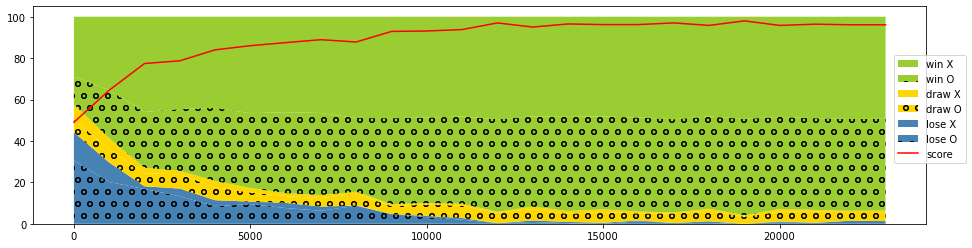

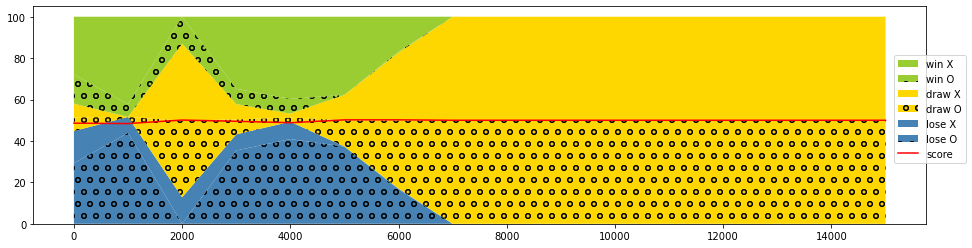

In [15]:
for agent in [agent_1, agent_3]:
    print(f"Train history of {agent.name}:")
    plot_train_history(agent)

На основе игры агентов `agent_1` и `agent_3` наш **Baseline** (выше) находится на уровне 93-95% выигрышей против необученного агента и 100% ничьих с хорошо обученным агентом. Отметим, что наиболее сильные агенты 1 и 3 иногда допускают проигрыши (до 1%), т.к. в процессе обучения они не рассмотрели все возможные позиции.

In [16]:
# check number of positions learned. Theoretical max = 5890
len (agent_1.V), len (agent_3.V)

(4790, 4555)

## Agent with Neural Network

In [17]:
class NN_Simple(nn.Module):
    """
    Полносвязная сеть для игры в крестики-нолики
    """

    def __init__(self):
        super(NN_Simple, self).__init__()
        self.fc1 = nn.Linear(27, 144)
        self.fc2 = nn.Linear(144, 36)
        self.fc3 = nn.Linear(36, 9)

    def convert_input(self, x):
        # Преобразуем игровое поле в три набора бинарных величин (X, O, пустое)
        x = torch.cat((x == 1, x == -1, x == 0), dim=-1).type(torch.float32)
        return x

    def forward(self, x0):
        x0 = self.convert_input(x0)
#         print (x0)
        x = torch.relu(self.fc1(x0))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

In [18]:
class ReplayMemory(object):
    """ basic replay memory class with cyclical buffer """

    def __init__(self, capacity=1000):
        self.capacity = capacity
        self.flush()

    def flush(self):
        self.memory = []
        self.position = 0

    def push(self, state, move, reward, new_state, done):
        transition = (state, move, reward, new_state, done)
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def push_batch(self, batch):
        state, move, reward, new_state, done = batch
        for i in range(len(move)):
            self.push(state[i], move[i], reward[i], new_state[i], done[i])

    def sample(self, batch_size):
        # allows for smaller batches if memory not well populated
        batch_size = min(batch_size, self.__len__())
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
class ReplayMemory2():
    """ separate memories for positive and negative experiences """
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.positives = ReplayMemory(capacity=capacity//2)
        self.negatives = ReplayMemory(capacity=capacity//2)

    def push_batch (self, batch):
        if batch[2][-1] <0:  # checking reward for the last move in batch
            self.negatives.push_batch(batch)
        else:
            self.positives.push_batch(batch)
    
    def push(self, state, action, new_state, reward, done):
        raise NotimplementedError
        
    def sample(self, batch_size):
        posi_size = min (len(self.positives), batch_size//2)
        nega_size = min (len(self.negatives), batch_size - posi_size)
        if nega_size < batch_size //2:
            posi_size = batch_size - nega_size
        posi_sample = self.positives.sample(posi_size)
        nega_sample = self.negatives.sample(nega_size)
        return  posi_sample + nega_sample
                
    def __len__(self):
        return min(self.positives.__len__(), self.negatives.__len__())*2

In [20]:
class Agent_NN_Q(Agent):
    """
    Агент для игры в крестики-нолики.
    Обучается с подкреплением методом Q-Learning
    """

    def __init__(self, name="Agent_NN_Q_instance", game_class=TicTacToeGame, epsilon=0.1,
                 net=NN_Simple(), player_mark=1, lr=0.01, gamma=0.99, batch_size=32,
                 memory_capacity=400, update_target_frequency=10):
        super(Agent_NN_Q, self).__init__(
            game_class, name, epsilon, player_mark)

        self.nn = net.to(device)
        self.target_nn = copy.deepcopy(self.nn).to(device)
        self.loss_func = torch.nn.MSELoss
        self.optimizer = torch.optim.SGD(params=self.nn.parameters(), lr=lr)
        self.update_target_frequency = update_target_frequency
        self.update_target_counter = 0
        self.memory = ReplayMemory2(capacity=memory_capacity)
        self.batch_size = batch_size
        self.gamma = gamma

    def get_states_values(self, game):
        nn_input = game.player * \
            torch.Tensor(game.state).to(device)
        state_values = self.nn(nn_input).detach().squeeze(0).cpu().numpy()
        return {i: v for i, v in enumerate(state_values) if i in game.vacant_cells}

    def learn_from_move(self, game):
        state0 = [s * self.player_mark for s in game.state]
        self.history['positions'].append(state0)
        best_next_move, selected_next_move = self.learn_select_move(game)
        self.history['moves'].append(selected_next_move)
        reward = game.make_move(selected_next_move)
        self.history['rewards'].append(0)  # final reward applied later

    def random_move(self, game):
        return random.choice(game.vacant_cells)

    def process_learning(self):
        # repackage episode history and load it to memory
        moves_made = len(self.history['moves'])

        state = self.history['positions'][:-1]
        move = self.history['moves']
        reward = [0] * moves_made
        reward[-1] = self.history['rewards'][-1]
        new_state = self.history['positions'][1:]
        done = [0] * moves_made
        done[-1] = 1
        self.memory.push_batch((state, move, reward, new_state, done))

        self.optimize()  # call optimize to train the NN
        

    def optimize(self):
        """
        train NN based on sample from memory
        """
        state, move, reward, new_state, done = \
            zip(*self.memory.sample(self.batch_size))
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor(reward).to(device)
        done = torch.Tensor(done).to(device)

        predicted_value = self.nn(state)

        target_value = predicted_value.clone().detach()

        legal_moves = (state == 0).type(torch.float32)
        target_value = target_value * legal_moves  # 0 for non-legal moves

        new_state_values = self.target_nn(new_state).detach()
        # calculte reward for cells with moves
        qv = torch.max(new_state_values, axis=1).values
        reward[done == 0] = self.gamma * qv[done == 0]
        # apply reward for cells with moves
        target_value[np.arange(state.shape[0]), move] = reward

        loss = self.loss_func()(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.update_target_counter % self.update_target_frequency == 0:  # update target_nn
            self.target_nn.load_state_dict(self.nn.state_dict())
        self.update_target_counter += 1

### Тест обучения ПОЛНОСВЯЗНОЙ сети

In [21]:
agent_q = Agent_NN_Q(name='Agent_Q', gamma=0.95, lr=0.1, epsilon=0.7,
                       net=NN_Simple(), batch_size=32, memory_capacity=300,
                      update_target_frequency = 10)

train_agent(agent_q,  train_opponent=agent_0, test_opponent=agent_0,
            max_games=200000, eps_anneal=150000, early_stop=False,
            test_num_episodes=1000, train_num_episodes=10000, player_mark=-1)

agent Agent_Q training vs Agent_0
     test opponent: Agent_0


Games:     W, L, D      W, L, D       Win, Lose, Draw         score    epsilon
    0: [X] 67,21,12 [O] 37,51,12 [XO] 51.8, 35.8, 12.4 [SCORE] 58.0 [ε] 0.700
10000: [X] 95,3,2   [O] 74,25,1  [XO] 84.6, 13.7, 1.7  [SCORE] 85.4 [ε] 0.653
20000: [X] 96,2,2   [O] 82,14,4  [XO] 88.8, 8.3, 2.9   [SCORE] 90.2 [ε] 0.607
30000: [X] 96,1,3   [O] 83,12,5  [XO] 89.7, 6.1, 4.2   [SCORE] 91.8 [ε] 0.560
40000: [X] 96,1,3   [O] 85,9,7   [XO] 90.4, 4.9, 4.7   [SCORE] 92.8 [ε] 0.513
50000: [X] 97,0,3   [O] 86,10,4  [XO] 91.7, 5.0, 3.3   [SCORE] 93.4 [ε] 0.467
60000: [X] 97,0,3   [O] 83,10,7  [XO] 89.8, 5.0, 5.2   [SCORE] 92.4 [ε] 0.420
70000: [X] 96,0,4   [O] 85,3,12  [XO] 90.7, 1.6, 7.7   [SCORE] 94.5 [ε] 0.373
80000: [X] 98,0,2   [O] 89,5,6   [XO] 93.3, 2.4, 4.3   [SCORE] 95.5 [ε] 0.327
90000: [X] 97,1,2   [O] 89,4,7   [XO] 93.0, 2.8, 4.2   [SCORE] 95.1 [ε] 0.280
100000: [X] 97,0,2   [O] 90,2,9   [XO] 93.6, 0.9, 5.5   [SCORE] 96.3 [ε] 0.233
110000: [X] 97,0,3   [O] 90,0,9   [XO] 93.7, 0.2, 6.1   [SCORE

In [22]:
test_agent(agent=agent_q, opponents=[agent_0, agent_x, agent_o, agent_1, agent_2, agent_3, agent_q])

Testing agent 'Agent_Q' for 1000 games vs:
                 W, L, D      W, L, D       Win, Lose, Draw         score
Agent_0:     [X] 96,0,4   [O] 88,0,12  [XO] 92.2, 0.0, 7.8   [SCORE] 96.1
Agent_X:     [X] 95,0,5   [O] 0,0,100  [XO] 47.5, 0.0, 52.5  [SCORE] 73.8
Agent_O:     [X] 0,0,100  [O] 89,0,11  [XO] 44.7, 0.0, 55.3  [SCORE] 72.3
Agent_1:     [X] 0,0,100  [O] 0,0,100  [XO] 0.0, 0.0, 100.0  [SCORE] 50.0
Agent_2:     [X] 95,0,5   [O] 54,0,46  [XO] 74.7, 0.0, 25.3  [SCORE] 87.4
Agent_3:     [X] 0,0,100  [O] 0,0,100  [XO] 0.0, 0.0, 100.0  [SCORE] 50.0
Agent_Q:     [X] 0,0,100  [O] 0,0,100  [XO] 0.0, 0.0, 100.0  [SCORE] 50.0



После 200 тыс игр, наш агент показывает искомые результаты:  Обученный агент уверенно побеждает слабых противников и играет вничью с сильными. При этом ни разу не проигрывает!